# Speech Enhancement

In [3]:
!pip install pesq pystoi librosa scipy pandas seaborn tqdm soundfile

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262949 sha256=be44edfbfcd5236e7fe85b4d41943de72cd81e5e8ada9ef2ccebbe04c1bfff68
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
from pesq import pesq
from pystoi import stoi


In [5]:
def slice_signal_serialized(file_path):
    """Get signals from serialized numpy file"""
    data_pair = np.load(file_path)
    return data_pair[0], data_pair[1]  # clean, noisy

def evaluate_segments_serialized(serialized_dir, enhanced_dir, num_files=10, output_dir="evaluation_results"):
    """Evaluate metrics for segments using serialized data files"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Get sorted list of enhanced files
    enhanced_files = sorted([
        f for f in os.listdir(enhanced_dir) 
        if f.endswith('_e1.wav')
    ])
    
    if not enhanced_files:
        print("No enhanced files found")
        return None
    
    # Limit to specified number of files
    enhanced_files = enhanced_files[:num_files]
    print(f"\nEvaluating {len(enhanced_files)} files...")
    
    all_metrics = []
    
    for enhanced_file in tqdm(enhanced_files, desc="Processing files"):
        try:
            # Get corresponding serialized file name
            # Convert enhanced filename format (p232_001.wav_0_e1.wav) to serialized format (p232_001.wav_0.npy)
            base_name = enhanced_file.replace('_e1.wav', '.npy')
            
            # Construct file paths
            serialized_file_path = os.path.join(serialized_dir, base_name)
            enhanced_file_path = os.path.join(enhanced_dir, enhanced_file)
            
            if not os.path.exists(serialized_file_path):
                print(f"Serialized file not found: {serialized_file_path}")
                continue
            
            # Get clean and noisy segments from serialized file
            clean_segment, noisy_segment = slice_signal_serialized(serialized_file_path)
            
            # Get enhanced segment
            enhanced_segment, _ = librosa.load(enhanced_file_path, sr=16000)
            
            # Calculate enhanced metrics
            metrics = {
                'file': base_name,
                'type': 'enhanced',
                'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
            }
            
            pesq_score = pesq(16000, clean_segment, enhanced_segment, 'wb')
            stoi_score = stoi(clean_segment, enhanced_segment, 16000, extended=False)
            
            metrics['pesq'] = float(pesq_score)
            metrics['stoi'] = float(stoi_score)
            metrics['csig'] = float(3.093 - 1.029 * pesq_score + 0.603 * stoi_score)
            metrics['cbak'] = float(1.634 + 0.478 * pesq_score + 0.071 * stoi_score)
            metrics['covl'] = float(1.594 + 0.805 * pesq_score + 0.512 * stoi_score)
            
            all_metrics.append(metrics)
            
            # Calculate noisy metrics
            noisy_metrics = {
                'file': base_name,
                'type': 'noisy',
                'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
            }
            
            pesq_score = pesq(16000, clean_segment, noisy_segment, 'wb')
            stoi_score = stoi(clean_segment, noisy_segment, 16000, extended=False)
            
            noisy_metrics['pesq'] = float(pesq_score)
            noisy_metrics['stoi'] = float(stoi_score)
            noisy_metrics['csig'] = float(3.093 - 1.029 * pesq_score + 0.603 * stoi_score)
            noisy_metrics['cbak'] = float(1.634 + 0.478 * pesq_score + 0.071 * stoi_score)
            noisy_metrics['covl'] = float(1.594 + 0.805 * pesq_score + 0.512 * stoi_score)
            
            all_metrics.append(noisy_metrics)
            
        except Exception as e:
            print(f"Error processing {enhanced_file}: {str(e)}")
            continue
            
    if all_metrics:
        # Convert to DataFrame
        metrics_df = pd.DataFrame(all_metrics)
        
        # Save detailed CSV
        csv_path = os.path.join(output_dir, f'metrics_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.csv')
        metrics_df.to_csv(csv_path, index=False)
        print(f"\nDetailed results saved to: {csv_path}")
        
        # Save summary statistics
        summary = metrics_df.groupby('type')[['pesq', 'stoi', 'csig', 'cbak', 'covl']].agg(['mean', 'std'])
        summary_path = os.path.join(output_dir, f'summary_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.csv')
        summary.to_csv(summary_path)
        print(f"Summary statistics saved to: {summary_path}")
        
        return metrics_df
    else:
        print("No metrics collected")
        return None

In [6]:
print(len(os.listdir("/kaggle/input/segan-dataset/data/data/serialized_test_data")))

2805


In [7]:
metrics_df = evaluate_segments_serialized(
    serialized_dir="/kaggle/input/segan-dataset/data/data/serialized_test_data",
    enhanced_dir="/kaggle/input/segan-dataset/results/results",
    num_files=2805,
    output_dir="evaluation_results_all"
)


Evaluating 2805 files...


Processing files:   5%|▌         | 141/2805 [00:53<09:54,  4.48it/s] 

Error processing p232_021.wav_8_e1.wav: b'No utterances detected'


Processing files:   9%|▉         | 246/2805 [01:21<08:08,  5.24it/s]

Error processing p232_048.wav_0_e1.wav: b'No utterances detected'


Processing files:  75%|███████▌  | 2104/2805 [09:43<03:03,  3.81it/s]

Error processing p257_214.wav_0_e1.wav: b'No utterances detected'


Processing files:  96%|█████████▌| 2684/2805 [12:23<00:27,  4.33it/s]

Error processing p257_393.wav_0_e1.wav: b'No utterances detected'


Processing files: 100%|██████████| 2805/2805 [12:57<00:00,  3.61it/s]


Detailed results saved to: evaluation_results_all/metrics_20250110_193209.csv
Summary statistics saved to: evaluation_results_all/summary_20250110_193209.csv


# Analysing the results

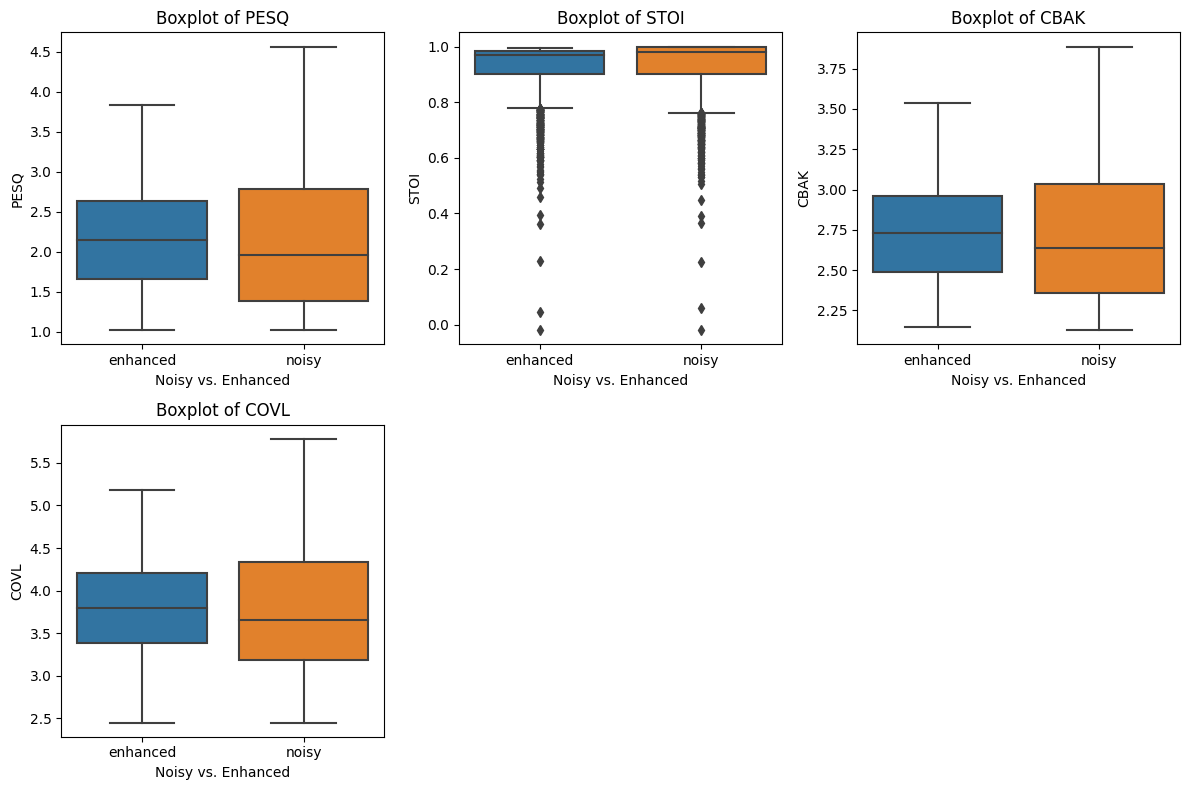

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths (update with actual paths)
metrics_path = "/kaggle/working/evaluation_results_all/metrics_20250110_193209.csv"
summary_path = "/kaggle/working/evaluation_results_all/metrics_20250110_193209.csv"

# Load the CSV files
metrics_df = pd.read_csv(metrics_path)
summary_df = pd.read_csv(summary_path)

metrics = ['pesq', 'stoi', 'cbak', 'covl']

# Plot boxplots for the metrics by type (enhanced vs noisy)
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=metrics_df, x='type', y=metric)
    plt.title(f"Boxplot of {metric.upper()}")
    plt.xlabel("Noisy vs. Enhanced")
    plt.ylabel(metric.upper())

plt.tight_layout()
plt.show()
